In [2]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PyQt5 import QtWidgets

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [4]:
# pip install opencv-contrib-python==3.4.2.17
# pip install matplotlib==3.1.1
# pip install PyQt5==5.15.1
# pip install tensorflow-gpu==2.10.0
# pip install tensorflow-addons[tensorflow-gpu]

In [5]:
import os

root = "Dataset_OpenCvDl_Hw2_Q5"
num_skipped = 0
for dateset_name in ("inference_dataset", "training_dataset", "validation_dataset"):
    for folder_name in ("Cat", "Dog"):
        folder_path = os.path.join(root, dateset_name, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                # os.remove(fpath)
                # Renaming the file
                os.rename(fpath, os.join("corrupt_imgs", f"corrupt{num_skipped}"))

print("Deleted %d images" % num_skipped)

Deleted 0 images


Found 15169 files belonging to 2 classes.
Found 1672 files belonging to 2 classes.
Found 10 files belonging to 2 classes.


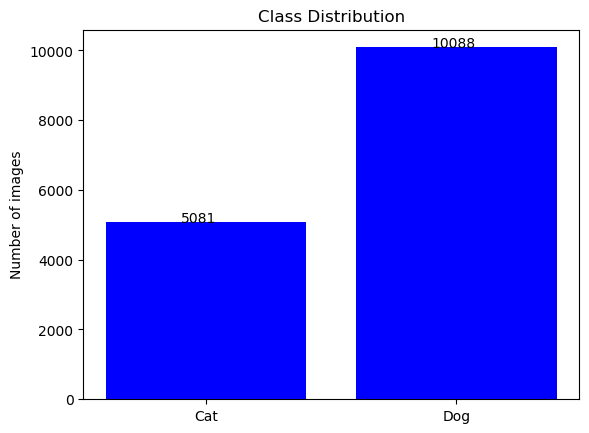

In [7]:
image_size = (224, 224)
batch_size = 128

train_path="Dataset_OpenCvDl_Hw2_Q5/training_dataset"
test_path="Dataset_OpenCvDl_Hw2_Q5/inference_dataset"
val_path="Dataset_OpenCvDl_Hw2_Q5/validation_dataset"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names

# 算label
sum=0
for batch in train_ds:
    imgs = batch[0]
    labels = batch[1]
    sum+=labels.numpy().sum()

# 畫圖
numbers = [15169-sum, sum]
x = np.arange(len(class_names))
bars = plt.bar(x, numbers, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.3, yval + 1, yval)
plt.xticks(x, class_names)
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.show()

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97095597


In [9]:
resnet50 = ResNet50(weights='imagenet')
dense = tf.keras.layers.Dense(1, activation='sigmoid')(resnet50.output)
model = tf.keras.models.Model(inputs=resnet50.input, outputs=dense)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(8e-5),
#     # loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.4, gamma=1.0),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    # validation_data = val_ds
)

Epoch 1/10
119/119 [==============================] - 2375s 20s/step - loss: 0.1492 - accuracy: 0.9565 - val_loss: 0.1470 - val_accuracy: 0.9462
Epoch 2/10
119/119 [==============================] - 2384s 20s/step - loss: 0.1444 - accuracy: 0.9850 - val_loss: 0.1430 - val_accuracy: 0.9725
Epoch 3/10
119/119 [==============================] - 2398s 20s/step - loss: 0.1411 - accuracy: 0.9889 - val_loss: 0.1399 - val_accuracy: 0.9779
Epoch 4/10
119/119 [==============================] - 2397s 20s/step - loss: 0.1385 - accuracy: 0.9881 - val_loss: 0.1381 - val_accuracy: 0.9677
Epoch 5/10
119/119 [==============================] - 2396s 20s/step - loss: 0.1363 - accuracy: 0.9905 - val_loss: 0.1352 - val_accuracy: 0.9839
Epoch 6/10
119/119 [==============================] - 2435s 20s/step - loss: 0.1342 - accuracy: 0.9929 - val_loss: 0.1334 - val_accuracy: 0.9874
Epoch 7/10
119/119 [==============================] - 2418s 20s/step - loss: 0.1323 - accuracy: 0.9956 - val_loss: 0.1324 - val_ac

In [ ]:
model.save("resnet50_SigmoidFocalCrossEntropy_15.h5")

In [16]:
model = tf.keras.models.load_model('resnet50_SigmoidFocalCrossEntropy_10.h5') # best
# model = tf.keras.models.load_model('resnet50_binarycrossentropy_3.h5') # second


# ds = tf.keras.utils.image_dataset_from_directory("C:\\Users\\BMILAB\\Desktop\\CVDL2022\\Hw2\\Dataset_OpenCvDl_Hw2_Q5\\inference_dataset\\Cat\\8046.jpg")
# print(ds)
img = cv2.imread("Dataset_OpenCvDl_Hw2_Q5/inference_dataset/Cat/8046.jpg")
img = cv2.resize(img, (224, 224))
# model = tf.keras.models.load_model('resnet50_SigmoidFocalCrossEntropy_10.h5') # best
print(img.shape)
result = model.predict(np.reshape(img,(1,224,224,3)))
print(result)

(224, 224, 3)
1/1 [==============================] - 1s 828ms/step
[[0.47064608]]


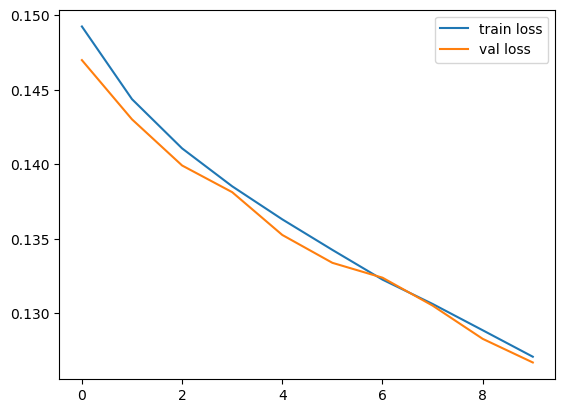

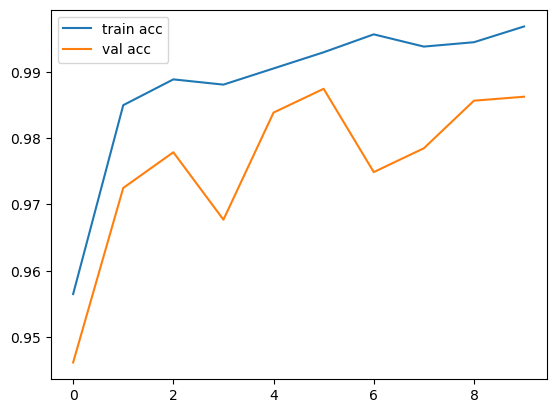

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
prediction=model.evaluate(test_ds)
for batch in test_ds:
    imgs = batch[0]
    labels= batch[1]
    predict = model.predict(imgs).flatten()
    predict[predict<0.5]=0
    predict[predict>=0.5]=1
    print(predict.astype(np.uint8))
    print(labels.numpy().astype(np.uint8))

1/1 [==============================] - 1s 1s/step
[0 0 1 1 0 0 1 1 0 1]
[0 0 1 1 0 0 1 1 0 1]
